In this file we generate particle flow trajectories in 2D turbulent Navier-Stokes flow. The flow information is assumed to be available in a series of snapshots. Therefore the minimum time step for particle trajectories generated here is equal to that of the snapshots. For 4th order Runge-Kutta, the minimum time step is twice that of the snapshots. 

In [1]:
# add parent folder to search directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from MR import MaxeyRiley
from flow_interpolater import flow_interpolater

In [3]:
fi = flow_interpolater('interpolaters/Re250_force06_k15_interp4000.npz')

# print(ff.t_index(.402, False))
X = np.array([3*np.pi/128, 2*np.pi/128])
print(fi.vel(X, 0.038))

[-1.88559553  1.6957867 ]


# Single Particle

Run script below if want to get a SINGLE TEST TRAJECTORY and verify things such as stability

In [4]:
np.random.seed(6666)

ep, R = .05, 1.55
mr = MaxeyRiley(ep=ep, R=R, flow=fi)
dt = 4e-3
x0 = np.random.rand(2,)*2*np.pi
v0 = mr.order1_manifold_vel(x0)
x, v, u, DuDt, vm = [], [], [], [], []
lmin = []
t = 0
traj_len = 1200

for i in range(traj_len):
    
    x1, v1 = mr.RK4step(x0, v0, dt, t)
    u1 = fi.vel(x1, t+dt)
    DuDt1 = fi.DuDt(x1, t+dt)
    vm1 = u1 + ep*(3/2*R - 1)*DuDt1
        
    # record
    x.append(x1)
    v.append(v1)
    u.append(u1)
    DuDt.append(DuDt1)
    vm.append(vm1)
    lmin.append(fi.lmin(x1, t, 1/ep))
        
    # update
    x0, v0 = x1, v1
    t += dt

x, v, u, DuDt, vm = np.array(x), np.array(v), np.array(u), np.array(DuDt), np.array(vm)
lmin = np.array(lmin)

Plot stability for a single trajectory

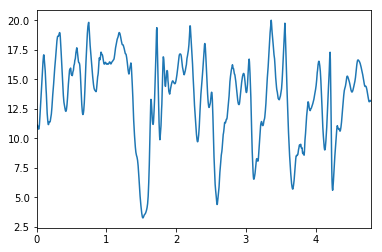

In [5]:
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(traj_len)*dt, lmin)
ax1.set_xlim([0, traj_len*dt])
plt.show()

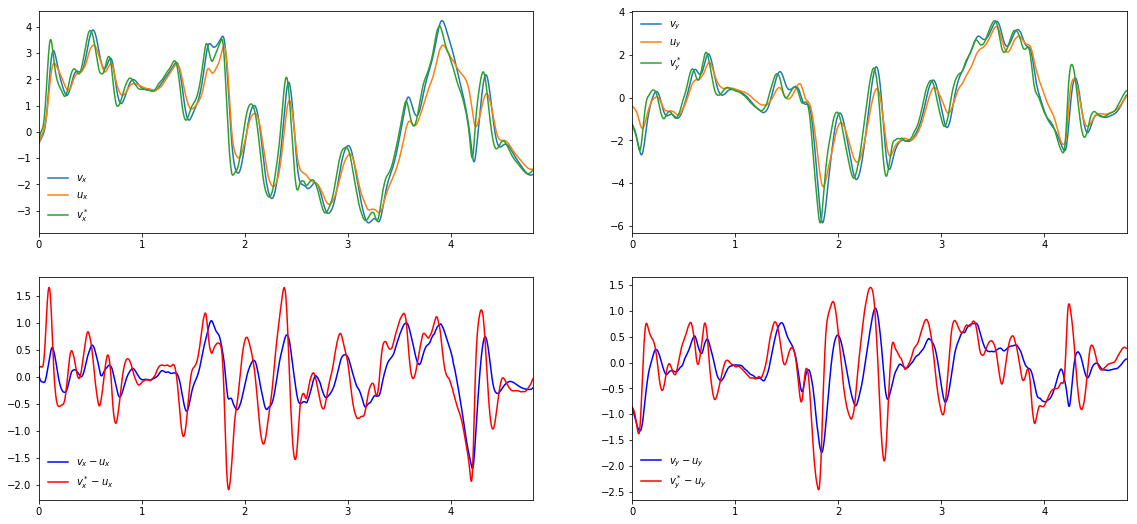

In [6]:
# plot velocity comparison
fig5, ax5 = plt.subplots(2, 2, figsize=(19.5, 9))
ax5[0,0].plot(np.arange(traj_len)*dt, v[:,0], label='$v_x$')
ax5[0,0].plot(np.arange(traj_len)*dt, u[:,0], label='$u_x$')
ax5[0,0].plot(np.arange(traj_len)*dt, vm[:,0], label='$v^*_x$')
ax5[0,0].set_xlim([0, traj_len*dt])
# ax5[0,0].set_xlim([.2, .4])
ax5[0,0].legend(frameon=False)

ax5[0,1].plot(np.arange(traj_len)*dt, v[:,1], label='$v_y$')
ax5[0,1].plot(np.arange(traj_len)*dt, u[:,1], label='$u_y$')
ax5[0,1].plot(np.arange(traj_len)*dt, vm[:,1], label='$v^*_y$')
ax5[0,1].set_xlim([0, traj_len*dt])
# ax5[0,1].set_xlim([.2, .4])
ax5[0,1].legend(frameon=False)

ax5[1,0].plot(np.arange(traj_len)*dt, v[:,0]-u[:,0], 'b-', label='$v_x - u_x$')
ax5[1,0].plot(np.arange(traj_len)*dt, vm[:,0]-u[:,0], 'r-', label='$v^*_x - u_x$')
ax5[1,0].set_xlim([0, traj_len*dt])
ax5[1,0].legend(frameon=False)

ax5[1,1].plot(np.arange(traj_len)*dt, v[:,1]-u[:,1], 'b-', label='$v_y - u_y$')
ax5[1,1].plot(np.arange(traj_len)*dt, vm[:,1]-u[:,1], 'r-', label='$v^*_y - u_y$')
ax5[1,1].set_xlim([0, traj_len*dt])
ax5[1,1].legend(frameon=False)

# Multiple Particles

Run script below to calculate A LARGE NUMBER OF TRAJECTORIES - for data generation purposes

In [15]:
np.random.seed(3333)

ep, R = .05, 1.55
mr = MaxeyRiley(ep=ep, R=R, flow=fi)
dt = 4e-3
pts = 5000    # number of pts/trajectories to generate

x0 = np.random.rand(pts, 2)*2*np.pi
v0 = mr.order1_manifold_vel(x0)
x, v, u, DuDt, vm = [], [], [], [], []
t = 0
traj_len = 1950

for i in range(traj_len):
    
    x1, v1 = mr.RK4step(x0, v0, dt, t)
    u1 = fi.vel(x1, t+dt)
    DuDt1 = fi.DuDt(x1, t+dt)
    vm1 = u1 + ep*(3/2*R - 1)*DuDt1
        
    # record
    x.append(np.mod(x1,2*np.pi))
    v.append(v1)
    u.append(u1)
    DuDt.append(DuDt1)
    vm.append(vm1)
        
    # update
    x0, v0 = x1, v1
    t += dt

# final 3D np arrays have dimension [timesteps, pts, 2]
x, v, u, DuDt, vm = np.array(x), np.array(v), np.array(u), np.array(DuDt), np.array(vm)

In [12]:
print(x.shape)

(1950, 1000, 2)


In [13]:
# save particle positions
# np.savez('particlex_1000by1200steps_ep015.npz', X=x)
sio.savemat('particlex_1000by1200steps_ep005.mat', {'X':x, 'dt_traj':dt, 't_max':traj_len*dt})

In [16]:
# save particle and local flow velocities (for checking probability density purpose mainly)
np.savez('Velocities.npz', V=v, U=u, DUDt=DuDt, Vm=vm);